# **JanataHack** - E-Commerce Analytics ML Hackathon


Thanks to Analytics Vidhya for organising such an initiative during the lockdown period due to COVID-19. 

JantaHack is an online Machine Learning Competition with the problem statement involving **Gender Prediction** from E-Commerce sessions given features such as timestamps of their session and list of products they visited.  


All the best to all the participants and Kudos to Winners.
Once again, Many thanks to Analytics Vidhya Team.

**Contents**

1. Very basic EDA, we did a little more extensive one and will be sharing that one as well.
2. Voting Classifier
3. BiLSTM Classifier
4. Submission Strategy


*We understand that many of the ideas we have used are not original or unique, therefore, we have tried to acknowledge. However, we might have missed some unintentionally, please let us know and accept our apologies.*

# ***Commencer***

In [0]:
# Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,BatchNormalization,Bidirectional,Embedding,Dropout
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
import missingno as msno 
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from collections import Counter
pio.templates.default = "plotly_dark"

## **Exploratory Data Analysis**

In [0]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [0]:
train.shape,test.shape

((10500, 5), (4500, 4))

**Checking for Missing Values**

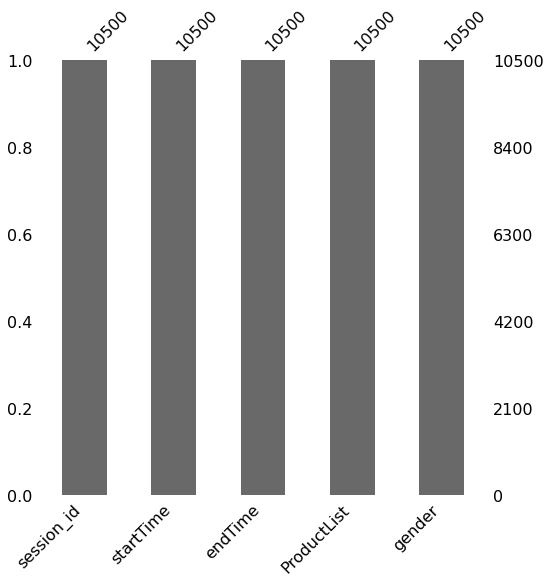

In [0]:
msno.bar(train,figsize=(8,8));

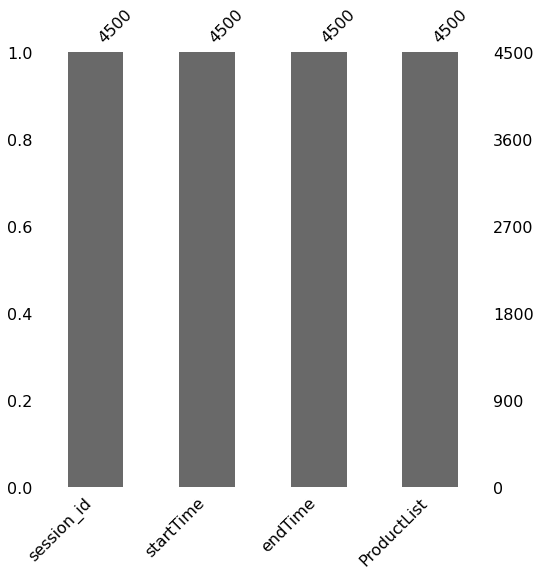

In [0]:
msno.bar(test,figsize=(8,8));

**Checking for Label Distribution**

In [0]:
fig = px.pie(pd.DataFrame(train['gender'].value_counts()),values='gender',names=['male','female'])
fig.show()

Tree based algorithms and Deep Learning models are not affected by this imbalance to that extend. Moreover, handling this imbalance resulted in drop in performance.

In [0]:
concat=pd.concat([train,test],ignore_index=True)
concat.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


### **Approach 1:** Feature Engineering and Machine Learning Models


Features in the dataset can be broadly categorised as following

#### **Temporal Features**


*   Hour of the Day --> *Maybe convert them to morning,afternoon,evening*
*   Day of the Week
*   Is Weekday or not


#### **Behavioural Features**



1.   Duration of Session (in minutes)
2.   Number of Products visited


#### **Product Features**


-  Dominant A category
-  Dominant B category
-  Dominant C category
-  First A category
-  First B category
-  Last A category
-  Last B category
-  Number of category A visits
-  Number of category B visits
-  Number of category C visits




---




---

**References**  
[1] Duc Duong, Hanh Tan and Son Pham, "Customer gender prediction based on E-commerce data," 2016 Eighth International Conference on Knowledge and Systems Engineering (KSE), Hanoi, 2016, pp. 91-95.


**Take Away:** Anything and Everything is a Feature!

In [0]:
concat_ml=concat.copy()

In [0]:

"""
  Extracting Temporal Features along with Duration
"""
def handle_time(df:pd.DataFrame)->pd.DataFrame:
  # Thanks to Analytics Vidhya's Slack group for JantaHack for helping out with the following snippet.
  df['startTime'] = pd.to_datetime(df['startTime'],format='%d/%m/%y %H:%M')
  df['endTime'] = pd.to_datetime(df['endTime'],format='%d/%m/%y %H:%M')
  df['duration'] = df['endTime'] - df['startTime']
  df['duration'] = df['duration'].astype('timedelta64[m]') #minute conversion
  df['weekday'] = df['startTime'].dt.dayofweek
  df['hour_24h'] = df['startTime'].dt.hour
  df['is_weekday'] = ((pd.DatetimeIndex(df['startTime']).dayofweek) // 5 == 1).astype(float)
  return df


"""
  Extract Number of Products
"""
def number_product(x):
    if ";"  in x:
        product_list = x.split(";")
        num_products = len(product_list)   
    else:
        num_products = 1
    return num_products    


"""
  Extract Dominant A,B,C
"""
def most_visited(x,return_col='A'):
    if ";"  in x:
        product_list = x.split(";")
        A_list =[]
        B_list =[]
        C_list =[]
        for item in product_list:
            A_list.append(item.split("/")[0])
            B_list.append(item.split("/")[1])
            C_list.append(item.split("/")[2])
        most_visited_A =  max(A_list, key=Counter(A_list).get)
        most_visited_B =  max(B_list, key=Counter(B_list).get) 
        most_visited_C =  max(C_list,key=Counter(C_list).get)      
    else:
        product_list = x.split("/")
        most_visited_A = product_list[0]
        most_visited_B = product_list[1]
        most_visited_C = product_list[2]
    if return_col is 'A':
      return most_visited_A  
    elif return_col is 'B':
      return most_visited_B
    else:
      return most_visited_C 
  

"""
  Number of Category visits
"""
def number_category_visits(x,return_col='A'):
  if ";"  in x:
        product_list = x.split(";")
        A_list =[]
        B_list =[]
        C_list =[]
        for item in product_list:
            A_list.append(item.split("/")[0])
            B_list.append(item.split("/")[1])
            C_list.append(item.split("/")[2])
        num_A = len(set(A_list))
        num_B = len(set(B_list))
        num_C = len(set(C_list))
  else:
      num_A = 1
      num_B = 1
      num_C = 1
  if return_col is 'A':
    return num_A
  elif return_col is 'B':
    return num_B
  else:
    return num_C



"""
  First Product
"""
def first_visit(x,return_col='A'):
  if ";"  in x:
        first_product = x.split(";")[0]
        product_list=first_product.split('/')
        first_A = product_list[0]
        first_B = product_list[1]
        
  else:
      product_list=x.split('/')
      first_A = product_list[0]
      first_B = product_list[1]
  if return_col is 'A':
    return first_A
  elif return_col is 'B':
    return first_B



"""
  Last Product
"""
def last_visit(x,return_col='A'):
  if ";"  in x:
        last_product = x.split(";")[-1]
        product_list=last_product.split('/')
        last_A = product_list[0]
        last_B = product_list[1]
        
  else:
      product_list=x.split('/')
      last_A = product_list[0]
      last_B = product_list[1]
  if return_col is 'A':
    return last_A
  elif return_col is 'B':
    return last_B

In [0]:
concat_ml=handle_time(concat_ml)

In [0]:
concat_ml['Num_Prod']=concat_ml['ProductList'].apply(lambda x:number_product(x))
concat_ml['Dominant_A']=concat_ml['ProductList'].apply(lambda x:most_visited(x,'A'))
concat_ml['Dominant_B']=concat_ml['ProductList'].apply(lambda x:most_visited(x,'B'))
concat_ml['Dominant_C']=concat_ml['ProductList'].apply(lambda x:most_visited(x,'C'))
concat_ml['Uni_A']=concat_ml['ProductList'].apply(lambda x:number_category_visits(x,'A'))
concat_ml['Uni_B']=concat_ml['ProductList'].apply(lambda x:number_category_visits(x,'B'))
concat_ml['Uni_C']=concat_ml['ProductList'].apply(lambda x:number_category_visits(x,'C'))

In [0]:
concat_ml.pop('ProductList');
# concat_ml.pop('session_id');
concat_ml.pop('startTime');
concat_ml.pop('endTime');

In [0]:
concat_ml.head()

,session_id,gender,duration,weekday,hour_24h,is_weekday,Num_Prod,Dominant_A,Dominant_B,Dominant_C,Uni_A,Uni_B,Uni_C
0,u16159,female,1.0,0,18,0.0,4,A00002,B00003,C00006,1,1,1
1,u10253,male,6.0,1,14,0.0,7,A00001,B00009,C00031,1,1,1
2,u19037,female,0.0,0,15,0.0,1,A00002,B00001,C00020,1,1,1
3,u14556,female,3.0,6,2,1.0,3,A00002,B00004,C00018,1,1,1
4,u24295,male,2.0,2,16,0.0,2,A00001,B00001,C00012,1,1,1


In [0]:
fig = px.histogram(concat_ml[concat_ml['gender'].notnull()], x="Dominant_A",color='gender')
fig.show()

In [0]:
fig = px.histogram(concat_ml[concat_ml['gender'].notnull()], x="Num_Prod",color='gender')
fig.show()

In [0]:
fig = px.scatter(concat_ml[concat_ml['gender'].notnull()], y="duration",color='gender')
fig.show()

In [0]:
max(concat_ml['duration'])
# Thats lot of time!

50752.0

In [0]:
l_A=LabelEncoder()
l_B=LabelEncoder()
l_C=LabelEncoder()

In [0]:
concat_ml['Dominant_A']=l_A.fit_transform(concat_ml['Dominant_A'])
concat_ml['Dominant_B']=l_A.fit_transform(concat_ml['Dominant_B'])
concat_ml['Dominant_C']=l_A.fit_transform(concat_ml['Dominant_C'])

In [0]:
train=concat_ml[concat_ml['gender'].notnull()]
test=concat_ml[concat_ml['gender'].isna()]

In [0]:
Dominant_As=concat_ml['Dominant_A'].unique()

In [0]:
submission=pd.DataFrame(columns=['session_id','gender'])
ensemble_ml=pd.DataFrame(columns=['session_id','predict_ml','prob_ml'])

In [0]:
for A in Dominant_As:
  
  train_A=train[train['Dominant_A']==A].copy()
  
  train_A.pop('session_id');
  
  train_Y = train_A.pop('gender').map({'female':1,'male':0})

  rf_clf=RandomForestClassifier(n_estimators=300)
  kn_clf=KNeighborsClassifier()
  xg_clf=XGBClassifier(n_estimators=200)
  lg_clf=LGBMClassifier(n_estimators=200)
  mp_clf=MLPClassifier(hidden_layer_sizes=(32,16,8))
  
  clf=VotingClassifier(
    estimators=[
                ('rf',rf_clf),
                ('kn',kn_clf),
                ('xg',xg_clf),
                ('lg',lg_clf),
                ('mp',mp_clf)
    ],
    voting='soft'
  )
  clf.fit(train_A,train_Y)
  
  test_A=test[test['Dominant_A']==A].copy()
  
  test_ids=test_A.pop('session_id')
  test_A.pop('gender')

  test_Y=clf.predict(test_A)
  predictions=pd.Series(test_Y)
  predictions=predictions.map({1:'female',0:'male'})
  predictions=predictions.to_list()

  sub_A=pd.DataFrame(columns=['session_id','gender'])
  sub_A['session_id']=test_ids
  sub_A['gender']=predictions
  submission=submission.append(sub_A)

  probilities=clf.predict_proba(test_A)
  ens_A=pd.DataFrame(columns=['session_id','predict_ml','prob_ml'])
  ens_A['session_id']=test_ids
  ens_A['predict_ml']=predictions
  ens_A['prob_ml']=probilities
  ensemble_ml=ensemble_ml.append(ens_A)

In [0]:
ensemble_ml.to_csv('ensemble_ml.csv',index=False)
submission.to_csv('submission_ml.csv',index=False)

We did not keep any validation data for above approach as we created a new model for each A category.
![Screenshot from 2020-04-13 18-24-47](https://user-images.githubusercontent.com/30664477/79121995-44330100-7db4-11ea-8023-3b7182f60dac.png)


Hower a simple around *91-93% validation accuracy* was achieved when a one model was used for entire data.

### **Approach 2:** *ProductList as the Star Feature*


Like mentioned earlier, we did come across some research papers, Khan et al.[1] in their work, used categories in `ProductList` as Bi-grams. This inspired us to assume `ProductList` as a sequence that describes the session of given user.


There, as a naive approach, we used the entire `ProductList` string as feature for Recurrent Neural Net Variants.

Upon experimenting, we found Bi-directional LSTMs to work the best.





---


---



**References**  
[2] Khan, M.M., Sohrab, M.G. & Yousuf, M.A. Customer gender prediction system on hierarchical E-commerce data. Beni-Suef Univ J Basic Appl Sci 9, 10 (2020). https://doi.org/10.1186/s43088-020-0035-7


In [0]:
concat_dl=concat.copy()

### Preprocessing and Fitting the models

In [0]:
product_list=concat_dl['ProductList'].values.tolist()

In [0]:
tokenizer=Tokenizer(split='/',num_words=None,lower=False,oov_token='<OOV>')
tokenizer.fit_on_texts(product_list)

In [0]:
sequences=tokenizer.texts_to_sequences(product_list)
padded_sequences=pad_sequences(sequences=sequences,padding='post')
padded_sequences.shape

(15000, 172)

In [0]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1,32))
model.add(Bidirectional(LSTM(32,activation='relu',return_sequences=True,recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(16,activation='relu',return_sequences=False),))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16,  activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))
# model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


# We struggled with this for almost a whole day, until we used the Embedding layer.

In [0]:
encoder = LabelEncoder()

In [0]:
# Run Again!
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
X=train['ProductList'].values.tolist()
Y=train['gender'].values.tolist()
train_X=tokenizer.texts_to_sequences(X)
train_X=pad_sequences(sequences=train_X,padding='post',maxlen=172)
train_Y=encoder.fit_transform(Y)

In [0]:
X_train,X_val,Y_train,Y_val=train_test_split(train_X,train_Y,test_size=0.2)

In [0]:
model.fit(X_train,Y_train,epochs=4,batch_size=16,validation_data=(X_val, Y_val));

Train on 8400 samples, validate on 2100 samples
Epoch 1/4
8400/8400 [==============================] - 133s 16ms/step - loss: 0.1960 - accuracy: 0.9407 - val_loss: 0.2101 - val_accuracy: 0.9448
Epoch 2/4
8400/8400 [==============================] - 132s 16ms/step - loss: 0.1841 - accuracy: 0.9494 - val_loss: 0.1870 - val_accuracy: 0.9429
Epoch 3/4
8400/8400 [==============================] - 132s 16ms/step - loss: 0.1681 - accuracy: 0.9538 - val_loss: 0.1753 - val_accuracy: 0.9495
Epoch 4/4
8400/8400 [==============================] - 132s 16ms/step - loss: 0.1514 - accuracy: 0.9620 - val_loss: 0.1819 - val_accuracy: 0.9457


We ran the above code cell multiple times along with pseudo labelled data, so exact `number of epochs` can vary, however total epochs were around 20+ with `batch_size` varying between 32 and 64.

### Pseudo Labelling



---



---

**References**  
[3] Lee, Dong-Hyun. (2013). Pseudo-Label : The Simple and Efficient Semi-Supervised Learning Method for Deep Neural Networks. ICML 2013 Workshop : Challenges in Representation Learning (WREPL).   


*Note: We could'nt trace the exact paper that first described the concept.*


In [0]:
pseudo_labels=pd.DataFrame(columns=train.columns)

for index,row in test.iterrows():
  x=[row['ProductList']]
  x=tokenizer.texts_to_sequences(x)
  x=pad_sequences(sequences=x,padding='post',maxlen=172)
  probability=model.predict_proba(x)
  prediction=model.predict_classes(x)
  if probability[0]>0.6:
    row['gender']=encoder.inverse_transform(prediction)[0]
    pseudo_labels=pseudo_labels.append(row)
    session_id=row['session_id']

In [0]:
pseudo_labels.shape

(1212, 5)

In [0]:
pseudo_labels.to_csv('pseudo_labels.csv',index=False)

In [0]:
train_dl=train.append(pseudo_labels)

In [0]:
X=train_dl['ProductList'].values.tolist()
Y=train_dl['gender'].values.tolist()
train_X=tokenizer.texts_to_sequences(X)
train_X=pad_sequences(sequences=train_X,padding='post',maxlen=172)
train_Y=encoder.transform(Y)

In [0]:
train_dl.shape

(11712, 5)

In [0]:
X_train,X_val,Y_train,Y_val=train_test_split(train_X,train_Y,test_size=0.2)

In [0]:
model.fit(X_train,Y_train,epochs=4,batch_size=32,validation_data=(X_val, Y_val));

Train on 9369 samples, validate on 2343 samples
Epoch 1/4
9369/9369 [==============================] - 90s 10ms/step - loss: 0.1189 - accuracy: 0.9651 - val_loss: 0.0912 - val_accuracy: 0.9710
Epoch 2/4
9369/9369 [==============================] - 87s 9ms/step - loss: 0.0982 - accuracy: 0.9702 - val_loss: 0.0861 - val_accuracy: 0.9714
Epoch 3/4
9369/9369 [==============================] - 88s 9ms/step - loss: 0.0933 - accuracy: 0.9718 - val_loss: 0.0945 - val_accuracy: 0.9684
Epoch 4/4
9369/9369 [==============================] - 88s 9ms/step - loss: 0.0839 - accuracy: 0.9762 - val_loss: 0.0993 - val_accuracy: 0.9693


We are overfitting but that can be fixed by steps such as reducing number of `epochs` or using a `callback`.

In [0]:
test_X=test['ProductList'].values.tolist()
test_X=tokenizer.texts_to_sequences(test_X)
test_X=pad_sequences(sequences=test_X,padding='post',maxlen=172)

In [0]:
predictions=model.predict_classes(test_X)
predictions_dl=encoder.inverse_transform(predictions.reshape(-1))
predictions_dl=predictions_dl.tolist()

In [0]:
submission_dl=pd.DataFrame(columns=['session_id','gender'])
submission_dl['session_id']=test['session_id']
submission_dl['gender']=predictions_dl

In [0]:
model.save('model_1.h5')

In [0]:
ensemble_dl=pd.DataFrame(columns=['session_id','predict_dl','prob_dl'])

for index,row in test.iterrows():
  x=[row['ProductList']]
  x=tokenizer.texts_to_sequences(x)
  x=pad_sequences(sequences=x,padding='post',maxlen=172)
  probability=model.predict_proba(x)
  prediction=model.predict_classes(x)
  r={
      'session_id':row['session_id'],
      'predict_dl':encoder.inverse_transform(prediction)[0],
      'prob_dl':probability.reshape(-1)[0].item()
  }
  ensemble_dl=ensemble_dl.append(r,ignore_index=True)

In [0]:
ensemble_dl.to_csv('ensemble_dl.csv',index=False)
submission.to_csv('submission_dl.csv',index=False)

## **Submission** 



In [0]:
# Confidence is the key!
# Ensembling Stratefy, use that classifier that has more confidence in its hypothesis.

ensemble_submission=pd.DataFrame(columns=['session_id','gender'])

for index,row in ensemble_ml.iterrows():
  ml_prob=row['prob_ml']
  ml_predict=row['predict_ml']
  sess_id=row['session_id']
  dl_row=ensemble_dl.query('session_id==@sess_id')
  dl_prob=dl_row['prob_dl']
  dl_predict=dl_row['predict_dl']
  if dl_prob.item()<ml_prob.item():
    ensemble_submission=ensemble_submission.append({'session_id':sess_id,'gender':ml_predict.item()},ignore_index=True)
  else:
    ensemble_submission=ensemble_submission.append({'session_id':sess_id,'gender':dl_predict.item()},ignore_index=True)

In [0]:
ensemble_submission.head()

In [0]:
ensemble_submission.to_csv('submission.csv',index=False)

As you can infer, we have 3 submission files from the notebook. However, due to time constraint, we could not implement this strategy completely as desired.

# ***Fin.***

*We explored other options as well such **Automated Machine Learning** and **Feed Forward Networks**, though they did'nt work that well (around 87-90%). We will be sharing them as well.*

**Suggestions and Healthy criticism are always Welcome!**